**Workflow: P/PET Average in April vs. in April 2020**

- connect to aWhere's API
- call ppet for April 2020 for test area (Yreka)
 - may have to make multiple requests
 - join data into 1 main dataframe
- get ppet for April 2019 for same site
- find difference in values and save to df
- call ppet for each site in grid geodataframe

In [13]:
import os

import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import pandas as pd
import geopandas as gpd
import earthpy as et

import requests as rq

from header import AWhereAPI
from secret_codes import *

In [2]:
# Import codes from secret_codes.py
api_key = API_KEY
api_secret = API_SECRET

In [44]:
# Create aWhere object
aw = AWhereAPI(api_key, api_secret)

# To get auth token, encode secret and key
sc = aw.encode_secret_and_key(API_KEY, API_SECRET)

# Then call auth token
token = aw.get_oauth_token(sc)

# Set up headers: auth and specific header for agronomics data
auth_headers = {"Authorization": "Bearer %s" % token,
                "Content-Type": 'application/json'}

agro_header = {"Authorization":  "Bearer %s" % token}

# General aWhere API endpoint "prefix"
endpt = "https://api.awhere.com"

In [4]:
# Function to fetch agronomic norms json
# given lat, long, start, end day (not year)
def agro_json(start_day, end_day, latitude, longitude, search_type):

    hist_ag_url = f"/v2/agronomics/locations/{latitude},{longitude}/agronomic{search_type}/{start_day},{end_day}"
    
    ag_norms_period = rq.get((endpt + hist_ag_url), headers=agro_header).json()
    
    return ag_norms_period

In [5]:
# Return average ppet for April

latitude = 41.726667
longitude = -122.6375

# Eash item is a range of dates
days_dict = {1: ["04-01", "04-10"],
             2: ["04-11", "04-20"],
            3: ["04-21", "04-30"]}

# List to hold all returned JSONs
json_list = []

# Loop thru keys and get JSONs for specified date ranges
for key in days_dict.keys():

    start_day = days_dict[key][0]
    end_day = days_dict[key][1]

    period_json = agro_json(start_day, end_day, latitude, longitude, "norms")
    
    json_list.append(period_json)

In [6]:
# Holds relevant data from each date
master_list = []

for period_json in json_list:

    # For each day in all days in json
    for day in range(0, len(period_json['dailyNorms'])):

        # List to hold values from specific day
        day_list = []

        day_list.append(period_json['dailyNorms'][day].get('day'))

        # Get average ppet
        day_list.append(period_json['dailyNorms'][day].get('ppet').get('average'))

        # Get ppet stddev
        day_list.append(period_json['dailyNorms'][day].get('ppet').get("stdDev"))

        master_list.append(day_list)

# Convert master list to dataframe
ppet_april_norms = pd.DataFrame(master_list, columns=['day', 'avg', 'std'])

In [7]:
# Get April 2020 agronomic values

latitude = 41.726667
longitude = -122.6375

dates_dict = {1: ["2020-04-01", "2020-04-10"],
              2: ["2020-04-11", "2020-04-20"],
              3: ["2020-04-21", "2020-04-30"]}

# Holds all  returned JSONs 
json_list = []

for key in days_dict.keys():

    start_date = days_dict[key][0]
    end_date = days_dict[key][1]

    april_2020_json = agro_json(
        start_date, end_date, latitude, longitude, "values")

    json_list.append(april_2020_json)

master_list = []

for period_json in json_list:

    # For each day in all days in json
    for day in range(0, len(period_json['dailyValues'])):

        # List to hold values from specific day
        day_list = []

        day_list.append(period_json['dailyValues'][day].get('date'))

        # Get average ppet
        day_list.append(period_json['dailyValues'][day].get('ppet'))

        master_list.append(day_list)
        
ppet_april_2020 = pd.DataFrame(master_list, columns=['day', 'ppet'])

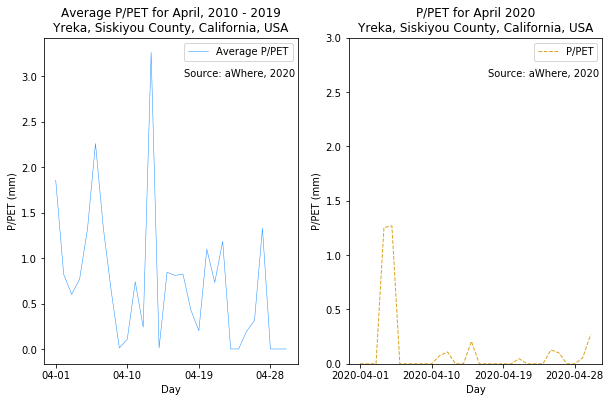

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,6))

# Set labels and title
ax1.set(title="Average P/PET for April, 2010 - 2019\n" +
       "Yreka, Siskiyou County, California, USA",
       xlabel="Day",
       ylabel="P/PET (mm)")

# Create plot of average P/PET
ax1.plot(ppet_april_norms.day, ppet_april_norms.avg, label="Average P/PET", linewidth=0.5, color='dodgerblue')

# Set ticker at regular intervals
tic = plticker.MultipleLocator(base=9.0)
ax1.xaxis.set_major_locator(tic)

# Show legend
ax1.legend()

# Add source info
ax1.text(0.55, 0.88, transform=ax1.transAxes, s="Source: aWhere, 2020")

"""Plot 2: This April"""
# Set labels and title
ax2.set(title="P/PET for April 2020\n" +
       "Yreka, Siskiyou County, California, USA",
       xlabel="Day",
       ylabel="P/PET (mm)")

# Create plot of average P/PE8
ax2.plot(ppet_april_2020.day, ppet_april_2020.ppet, label="P/PET", linewidth=1, color='goldenrod', linestyle='--')

# Set ticker at regular intervals
tic = plticker.MultipleLocator(base=9.0)
ax2.xaxis.set_major_locator(tic)

# Show legend
ax2.legend()

# Add source info
ax2.text(0.55, 0.88, transform=ax2.transAxes, s="Source: aWhere, 2020")

# Set axes to be the same
plt.ylim(0, 3)
plt.gca().set_aspect(aspect='auto', adjustable='box')

plt.show()

**Grid code below**

Goal: find daily historical average

- for each centroid, get average for month of April
 - from historical norms
- append to gdf

In [14]:
# Create path to grid geojson
grid_path = os.path.join(et.io.HOME, "Desktop", "drought", "data", "created", "aoi_polys.geojson")

# Read as gdf
aoi_grid = gpd.read_file(grid_path)

# Add centroid column 
aoi_grid['centroid'] = aoi_grid.geometry.apply(lambda poly: poly.centroid)

# add ppet column with values of 0 at first
aoi_grid = aoi_grid.assign(ppet = 0)

In [66]:


for index, row in aoi_test_grid.iterrows():
    latitude = row.centroid.y
    longitude = row.centroid.x
    
    start_day
    end_day
    
    # Get and parse json
    hist_ag_url = f"/v2/agronomics/locations/{latitude},{longitude}/agronomicnorms/{start_day},{end_day}"
    
    ag_norms_period = rq.get((endpt + hist_ag_url), headers=agro_header).json()
    
    return ag_norms_period
    
    ppet = daily_json.get('dailyValues')[0].get('ppet')
    
    aoi_grid.loc[index, 'ppet'] = ppet

aoi_grid

,geometry,centroid,ppet
0,"POLYGON ((-123.85503 40.97764, -123.77503 40.9...",POINT (-123.81503 41.01764),3.931476
1,"POLYGON ((-123.85503 41.05764, -123.77503 41.0...",POINT (-123.81503 41.09764),4.710463
2,"POLYGON ((-123.85503 41.13764, -123.77503 41.1...",POINT (-123.81503 41.17764),4.180506
3,"POLYGON ((-123.85503 41.21764, -123.77503 41.2...",POINT (-123.81503 41.25764),0.000000
4,"POLYGON ((-123.85503 41.29764, -123.77503 41.2...",POINT (-123.81503 41.33764),0.000000
...,...,...,...
517,"POLYGON ((-121.29503 41.69764, -121.21503 41.6...",POINT (-121.25503 41.73764),0.000000
518,"POLYGON ((-121.29503 41.77764, -121.21503 41.7...",POINT (-121.25503 41.81764),0.000000
519,"POLYGON ((-121.29503 41.85764, -121.21503 41.8...",POINT (-121.25503 41.89764),0.000000
520,"POLYGON ((-121.29503 41.93764, -121.21503 41.9...",POINT (-121.25503 41.97764),0.000000
